In [1]:
import json
import random
import pandas as pd
import numpy as np
from itertools import combinations, permutations
from tqdm.auto import tqdm

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# to split text into sentences
from nltk.tokenize import sent_tokenize

# train/test split, and evaluation
from sklearn.model_selection import train_test_split

# for model fine-tuning, inference
import torch
from torch.utils.data import Dataset, DataLoader

# LUKE model
from transformers import LukeTokenizer, LukeForEntityPairClassification, \
    DataCollatorWithPadding, AdamW, get_scheduler, DataCollatorForSeq2Seq

# REBEL model

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

plt.style.use('seaborn-v0_8')

/home/devuser1/miniconda3/envs/python3_11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_to_data = '../benchmark_data/'
path_to_models = 'models/'
path_to_results = 'results/'
path_to_plots = 'plots/'

# RE, Data

In [3]:
results = pd.DataFrame(columns=['model_name', 'macro_precision', 'macro_recall', 'macro_f1', 'p_works_at', 'p_partners_with', 'p_acquired_by', 'r_works_at', 'r_partners_with', 'r_acquired_by', 'f1_works_at', 'f1_partners_with', 'f1_acquired_by'])

In [4]:
class NoSentenceError(Exception):
    pass

def get_sentence(text, span):
    """Returns sentence for the given span"""

    sentences = sent_tokenize(text)
    for sentence in sentences:
        start_idx = text.find(sentence)
        end_idx = start_idx + len(sentence)
        if span[0] >= start_idx and span[1] <= end_idx:
            return sentence, start_idx
    
    raise NoSentenceError("entities are not in one sentence")

def adjust_span(span, offset):
    """Adjusts span"""

    return (span[0] - offset, span[1] - offset)

def transform_json_re(path, additional_rows=100):
    """Transfomrs json file into dataframe with entity relations, adds also rows with no relation"""

    with open(path) as f:
        data = json.load(f)

    texts = []
    entity_pairs = []
    entity_spans_pairs = []
    relation_labels = []

    total_additional_rows = 0

    for item in data:
        item_entities = {}
        text = item['data']['text']
        annotations = item['annotations'][0]['result']

        related_pairs = set()
        for annotation in annotations:

            # first create list of entities in this text
            if annotation['type'] == 'labels':
                entity_span = (annotation['value']['start'], annotation['value']['end'])
                entity_text = annotation['value']['text']
                entity_id = annotation['id']
                entity_label = annotation['value']['labels'][0]
                item_entities[entity_id] = {'text': entity_text, 'span': entity_span, 'label': entity_label}

            # create entity pairs according to annotations
            elif annotation['type'] == 'relation':
                from_entity = item_entities[annotation['from_id']]
                to_entity = item_entities[annotation['to_id']]
                try:
                    label = annotation['labels'][0]
                except KeyError:
                    # if the labels is missing skip annotation
                    continue

                from_span = from_entity['span']
                to_span = to_entity['span']

                try: 
                    if from_span[0] < to_span[0]:
                        sentence, offset = get_sentence(text, (from_span[0], to_span[1]))
                    else:
                        sentence, offset = get_sentence(text, (to_span[0], from_span[1]))
                except NoSentenceError as e:
                    print(e)
                    continue

                # adjust span of the entities according to the sentence
                from_span_adjusted = adjust_span(from_span, offset)
                to_span_adjusted = adjust_span(to_span, offset)

                # add relation to the dataframe
                texts.append(sentence)
                entity_pairs.append((from_entity['text'], to_entity['text']))
                entity_spans_pairs.append((from_span_adjusted, to_span_adjusted))
                relation_labels.append(label)

                # list of entity pairs that are actually related
                related_pairs.add((from_entity['text'], to_entity['text']))

        # create all possible pairs of the entities in this text
        all_entities = list(item_entities.values())
        all_pairs = list(permutations(all_entities, 2))

        # entity pairs that does not have a relation
        non_related_pairs = [(e1, e2) for e1, e2 in all_pairs if (e1['text'], e2['text']) not in related_pairs]

        random.seed(4)
        random.shuffle(non_related_pairs)
        for non_related_pair in non_related_pairs:
            if total_additional_rows >= additional_rows:
                break

            e1, e2 = non_related_pair
            from_span = e1['span']
            to_span = e2['span']

            try: 
                if from_span[0] < to_span[0]:
                    sentence, offset = get_sentence(text, (from_span[0], to_span[1]))
                else:
                    sentence, offset = get_sentence(text, (to_span[0], from_span[1]))
            except NoSentenceError as e:
                continue

            from_span_adjusted = adjust_span(from_span, offset)
            to_span_adjusted = adjust_span(to_span, offset)

            texts.append(sentence)
            entity_pairs.append((e1['text'], e2['text']))
            entity_spans_pairs.append((from_span_adjusted, to_span_adjusted))
            relation_labels.append('NIL')

            total_additional_rows += 1

    df = pd.DataFrame({'text': texts, 'entity_pairs': entity_pairs, 'entity_spans_pairs': entity_spans_pairs, 'label': relation_labels})
    return df


In [5]:
df_re = transform_json_re(path_to_data + 'annotations.json')

id2label = {0: 'NIL', 1: 'works_at', 2: 'partners_with', 3: 'acquired_by'}
label2id = {'NIL': 0, 'works_at': 1, 'partners_with': 2, 'acquired_by': 3}

train_split = pd.read_csv(path_to_data + 'train_test_split/train.csv')
test_split = pd.read_csv(path_to_data + 'train_test_split/test.csv')

train_df = pd.merge(df_re, train_split, how='inner', on='text')
test_df = pd.merge(df_re, test_split, how='inner', on='text')

df_re

entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence


,text,entity_pairs,entity_spans_pairs,label
0,A Ukrainian officer interviewed by The New Yor...,"(RT.com, Vladimir Zelensky)","((156, 162), (73, 90))",NIL
1,A Ukrainian officer interviewed by The New Yor...,"(The New Yorker, Vladimir Zelensky)","((35, 49), (73, 90))",NIL
2,A Ukrainian officer interviewed by The New Yor...,"(Vladimir Zelensky, The New Yorker)","((73, 90), (35, 49))",NIL
3,A Ukrainian officer interviewed by The New Yor...,"(RT.com, The New Yorker)","((156, 162), (35, 49))",NIL
4,A Ukrainian officer interviewed by The New Yor...,"(The New Yorker, RT.com)","((35, 49), (156, 162))",NIL
...,...,...,...,...
420,"said David Evans, CEO of TCG World.","(David Evans, TCG World)","((5, 16), (25, 34))",works_at
421,"""Downtown has a history of being at the forefr...","(Downtown, TCG World)","((1, 9), (173, 182))",partners_with
422,"Adds Loredana Cacciotti, EVP, Digital Revenue ...","(Loredana Cacciotti, Downtown Music)","((5, 23), (61, 75))",works_at
423,Azelis Expands Its Portfolio in Germany With t...,"(DBH Osthandelsgesellschaft mbH, Azelis)","((102, 132), (0, 6))",acquired_by


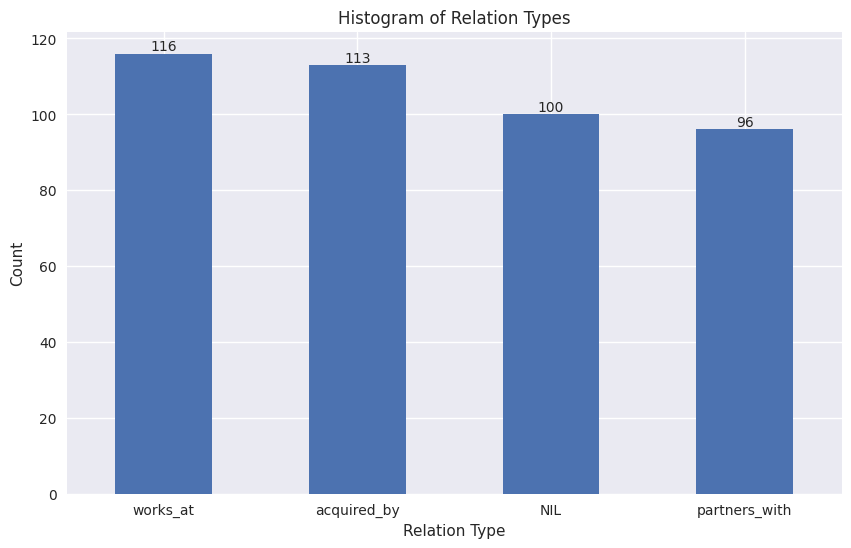

In [6]:
# histogram, relation types

plt.figure(figsize=(10, 6))
value_counts = df_re['label'].value_counts()
ax = value_counts.plot(kind='bar')

# Adding text annotations
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.xlabel('Relation Type')
plt.ylabel('Count')
plt.title('Histogram of Relation Types')
plt.xticks(rotation=0)
plt.savefig(path_to_plots + 'benchmark_for_re.png')
plt.show()


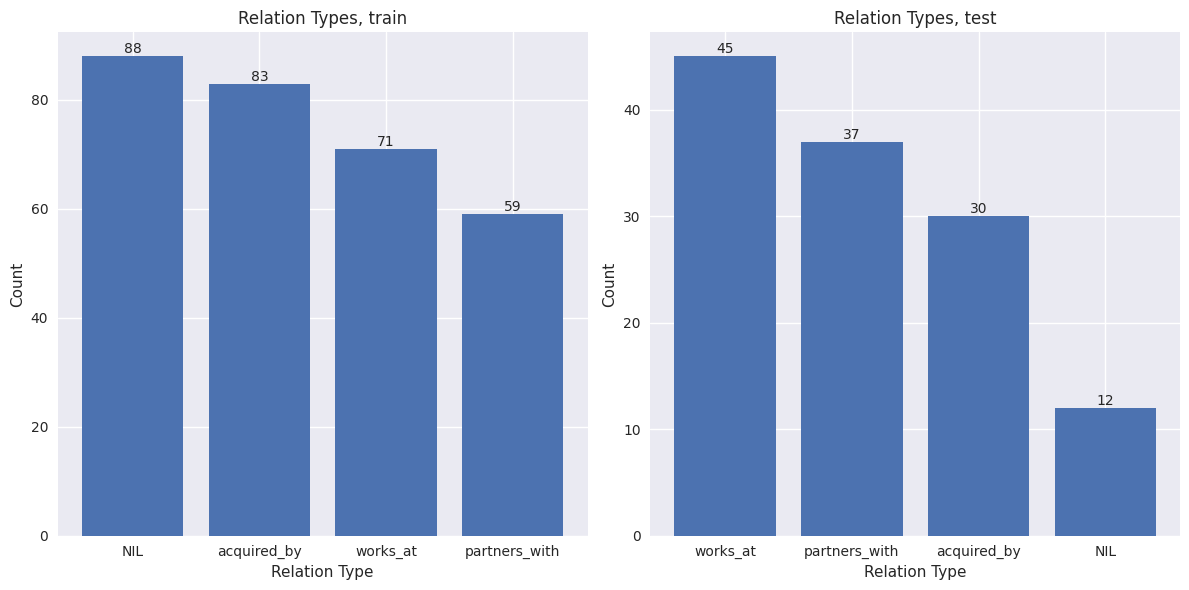

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

train_value_counts = train_df['label'].value_counts()
ax1.bar(train_value_counts.index, train_value_counts.values)

for i in ax1.patches:
    ax1.text(i.get_x() + i.get_width() / 2, i.get_height(), str(i.get_height()), ha='center', va='bottom')

ax1.set_xlabel('Relation Type')
ax1.set_ylabel('Count')
ax1.set_title('Relation Types, train')
ax1.tick_params(axis='x', rotation=0) 


test_value_counts = test_df['label'].value_counts()
ax2.bar(test_value_counts.index, test_value_counts.values)

for i in ax2.patches:
    ax2.text(i.get_x() + i.get_width() / 2, i.get_height(), str(i.get_height()), ha='center', va='bottom')

ax2.set_xlabel('Relation Type')
ax2.set_ylabel('Count')
ax2.set_title('Relation Types, test')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(path_to_plots + 'relation_test_train.png')

plt.show()


# RE, LUKE

In [8]:
# models' names
model_name_luke_base = "studio-ousia/luke-base"
model_name_nk_finetuned = "nk_LUKE_re"

task_pair_class = "entity_pair_classification"

# models
model_luke_base = LukeForEntityPairClassification.from_pretrained(model_name_luke_base, num_labels=len(label2id), id2label=id2label, label2id=label2id)

# tokenizer
tokenizer_luke_base = LukeTokenizer.from_pretrained(model_name_luke_base, task=task_pair_class)

# parameters for fine-tuning
train_batch = 4
test_batch = 2
epochs = 4
lr=5e-5

Some weights of LukeForEntityPairClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_luke_base.to(device)
device

device(type='cpu')

## 2. RE, LUKE: DataSet, tokenizer 

In [10]:
class RelationExtractionDataset(Dataset):
    """Relation extraction dataset."""

    def __init__(self, data, tokenizer):
        """
        Args:
            data : Pandas dataframe.
            tokenizer : tokenizer to encode data.
        """
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]

        text = item.text
        entity_spans = [tuple(x) for x in item.entity_spans_pairs]

        encoding = self.tokenizer(text, entity_spans=entity_spans, truncation=True, return_tensors="pt")

        for k,v in encoding.items():
          encoding[k] = encoding[k].squeeze()

        encoding["label"] = torch.tensor(label2id[item.label])

        return encoding
    
    def return_item(self, idx):

        item = self.data.iloc[idx]

        text = item.text
        entity_spans = [tuple(x) for x in item.entity_spans_pairs]
        entity_pair = item.entity_pairs
        label = item.label

        return text, entity_spans, entity_pair, label
    
def return_datasets_luke(test_df, train_df, tokenizer):
    test_dataset = RelationExtractionDataset(test_df, tokenizer)
    train_dataset = RelationExtractionDataset(train_df, tokenizer)

    return test_dataset, train_dataset


def return_dataloader_luke(test_df, train_df, tokenizer):
    # use DataCollator to implement padding for the batch ranther than the full dataset
    data_collator = DataCollatorWithPadding(tokenizer)

    test_dataset, train_dataset = return_datasets_luke(test_df, train_df, tokenizer)

    # suffle = Ture, suffle at the end of each epoch
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch, collate_fn=data_collator)
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, collate_fn=data_collator)

    return test_dataloader, train_dataloader

In [11]:
test_finetune_dataset, train_finetune_dataset = return_datasets_luke(test_df, train_df, tokenizer_luke_base)
test_finetune_dataloader, train_finetune_dataloader = return_dataloader_luke(test_df, train_df, tokenizer_luke_base)

## 3. RE, LUKE: test batch

In [12]:
for batch in test_finetune_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([2, 32]),
 'entity_ids': torch.Size([2, 2]),
 'entity_position_ids': torch.Size([2, 2, 30]),
 'attention_mask': torch.Size([2, 32]),
 'entity_attention_mask': torch.Size([2, 2]),
 'labels': torch.Size([2])}

In [13]:
tokenizer_luke_base.decode(batch['input_ids'][0])

'<s> <ent> FLX Networks <ent>  Partners with <ent2>  GK3 Capital <ent2>  to Provide Premier Digital Sales and Marketing for Asset Managers and Wealth Management Firms.</s>'

In [14]:
batch['labels'][0]

tensor(2)

In [15]:
outputs = model_luke_base(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.7487, grad_fn=<NllLossBackward0>) torch.Size([2, 4])


In [16]:
outputs.logits[0].argmax(-1).squeeze()

tensor(1)

## 4. RE, LUKE: model fine-tuning

In [17]:
# Define the training function
def train_model(model, dataloader, epochs=epochs, learning_rate=lr):
    model.train()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    num_training_steps = epochs * len(dataloader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    for epoch in range(epochs):
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        print(f"Epoch {epoch+1} completed with loss: {loss.item()}")


In [18]:
# Train the model
train_model(model_luke_base, train_finetune_dataloader)

/home/devuser1/miniconda3/envs/python3_11/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 76/76 [02:25<00:00,  1.91s/it]


Epoch 1 completed with loss: 0.16220197081565857


100%|██████████| 76/76 [02:23<00:00,  1.88s/it]


Epoch 2 completed with loss: 0.018222656100988388


100%|██████████| 76/76 [02:18<00:00,  1.83s/it]


Epoch 3 completed with loss: 0.00024732868769206107


100%|██████████| 76/76 [02:19<00:00,  1.83s/it]

Epoch 4 completed with loss: 0.005942297168076038


In [20]:
model_luke_base.save_pretrained(path_to_models + model_name_nk_finetuned)

## 5. RE, LUKE: Evaluation

In [17]:
def evaluate_luke_model(model, name, dataloader):
    model.eval()
    labels = []
    preds = []

    class_labels = [1, 2, 3]

    TP = {1:0, 2:0, 3:0}
    FP = {1:0, 2:0, 3:0}
    FN = {1:0, 2:0, 3:0}

    precisions = []
    recalls = []
    f1_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader):

            batch_labels = batch["labels"]

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1)

            labels.extend(batch_labels.numpy().tolist())
            preds.extend(batch_preds.numpy().tolist())
    
    for t, p in zip(labels, preds):
        if t == p: 
            if t == 0: # if entity pair has 'no_relation' skip
                continue
            elif t in class_labels: # entity type is correctly recognized by NER, TP 
                TP[p] = TP[p] + 1
        else:
            if t == 0: # 'no_relation' entity is classified, false positive for the predicted class
                FP[p] = FP[p] + 1
            elif p == 0: # false negative for the true class, as entity was not recognized
                FN[t] = FN[t] + 1
            else: # wrong entity type, flase negative for true class, false positive for predicted class
                FP[p] = FP[p] + 1
                FN[t] = FN[t] + 1

    try:
        for class_ in class_labels:
            precision_class = TP[class_] / (TP[class_] + FP[class_])
            recall_class = TP[class_] / (TP[class_] + FN[class_])

            precisions.append(precision_class)
            recalls.append(recall_class)
            f1_scores.append(2 * precision_class * recall_class / (precision_class + recall_class))

        macro_precision = sum(precisions) / len(class_labels)
        macro_recall = sum(recalls) / len(class_labels)
        macro_f1 = sum(f1_scores) / len(class_labels)

        print(name)
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(f"Precision macro: {macro_precision}")
        print(f"Recall macro: {macro_recall}")
        print(f"F1 Score macro: {macro_f1}")
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

    except ZeroDivisionError as e:
        print(e)
        macro_precision, macro_recall, macro_f1 = 0, 0, 0

    return [name, macro_precision, macro_recall, macro_f1] + precisions + recalls + f1_scores

In [18]:
model_nk_finetuned = LukeForEntityPairClassification.from_pretrained(path_to_models + model_name_nk_finetuned)

In [19]:
model_nk_finetuned_results = evaluate_luke_model(model_nk_finetuned, model_name_nk_finetuned, test_finetune_dataloader)

100%|██████████| 62/62 [00:05<00:00, 11.88it/s]

nk_LUKE_re
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Precision macro: 0.9517753047164813
Recall macro: 0.9835835835835836
F1 Score macro: 0.9664123393055978
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [20]:
results.loc[len(results)] = model_nk_finetuned_results
results

,model_name,macro_precision,macro_recall,macro_f1,p_works_at,p_partners_with,p_acquired_by,r_works_at,r_partners_with,r_acquired_by,f1_works_at,f1_partners_with,f1_acquired_by
0,nk_LUKE_re,0.951775,0.983584,0.966412,1.0,0.972973,0.882353,0.977778,0.972973,1.0,0.988764,0.972973,0.9375


## 6. RE, LUKE: Inference

In [21]:
def inference(model, tokenizer, number_of_items, dataset, seed=42):

    np.random.seed(seed)

    l = len(dataset.data)
    indx = random.sample(range(l), number_of_items)

    for i in indx:
            text, entity_spans, entity_pair, label = dataset.return_item(i)

            inputs = tokenizer(text, entity_spans=entity_spans, return_tensors="pt")

            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class_idx = logits.argmax(-1).item()
            print("Sentence:", text)
            print("Ground truth: ", str(entity_pair) , ' ', label)
            print("Predicted label: ", model.config.id2label[predicted_class_idx])
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

In [22]:
model_nk_finetuned = LukeForEntityPairClassification.from_pretrained(path_to_models + model_name_nk_finetuned)

In [23]:
inference(model_nk_finetuned, tokenizer_luke_base, 5, test_finetune_dataset)

Sentence: Embraer Partners with Horizon Air for Cutting-Edge Inventory Management Program.
Ground truth:  ('Embraer', 'Horizon Air')   partners_with
Predicted label:  partners_with
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: Embraer and Horizon Air have entered into an agreement for the Embraer Collaborative Inventory Planning (ECIP), a bespoke program The post Embraer Partners with Horizon Air for Cutting-Edge Inventory Management Program appeared first on Travel And Tour World.
Ground truth:  ('Embraer Partners', 'Horizon Air')   partners_with
Predicted label:  partners_with
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: Scottish Rail Holdings today announced that Joanne Maguire has been appointed interim Managing Director of ScotRail following Alex Hynes' two-year secondment to the UK Government Department for Transport.
Ground truth:  ('Joanne Maguire', 'ScotRail')   works_at
Predicted label:  works_at
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Sentence: Groundworks® Increases Ohio Footp

# REBEL

In [24]:
model_name_rebel = "Babelscape/rebel-large"
model_name_rebel_finetuned = "nk_REBEL_re"

tokenizer_rebel = AutoTokenizer.from_pretrained(model_name_rebel)
model_rebel = AutoModelForSeq2SeqLM.from_pretrained(model_name_rebel)

gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 3,
    "num_return_sequences": 1,
}

# parameters for fine-tuning
train_batch = 4
test_batch = 2
epochs = 4
lr=3e-5

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_rebel.to(device)
device

device(type='cpu')

## RE, REBEL: Data preparation

In [26]:
def transform_row(row, idx):
    context = row['text']
    subj, obj = row['entity_pairs']
    label = row['label']
    
    triplet = f"<triplet> {subj} <subj> {obj} <obj> {label}"
    
    return {
        'text': context,
        'triplets': triplet
    }

def transform_df_rebel(df):

    df_no_nil = df[df['label'] != 'NIL']
    transformed_data = [transform_row(row, idx) for idx, row in df_no_nil.iterrows()]
    transformed_df = pd.DataFrame(transformed_data)
    grouped_df = transformed_df.groupby('text', as_index=False).agg({'triplets': ' '.join})

    return grouped_df

In [27]:
class RelationExtractionDatasetREBEL(Dataset):
    """Relation extraction dataset."""

    def __init__(self, data, tokenizer):
        """
        Args:
            data : Pandas dataframe.
            tokenizer : tokenizer to encode data.
        """
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]

        text = item.text
        triplets = item.triplets

        encoding = self.tokenizer(text, truncation=True, return_tensors="pt")
        with self.tokenizer.as_target_tokenizer():
            targets = self.tokenizer(triplets, truncation=True, return_tensors="pt")

        for k,v in encoding.items():
          encoding[k] = encoding[k].squeeze()

        encoding["labels"] = targets['input_ids'].squeeze()

        return encoding


def return_dataloader_rebel(train_df, tokenizer):
    # use DataCollator to implement padding for the batch ranther than the full dataset

    data_collator = DataCollatorForSeq2Seq(tokenizer)
    train_dataset = RelationExtractionDatasetREBEL(train_df, tokenizer)

    # suffle = Ture, suffle at the end of each epoch
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, collate_fn=data_collator)

    return train_dataloader

In [28]:
test_df_rebel = transform_df_rebel(test_df)
train_df_rebel = transform_df_rebel(train_df)

train_rebel_dataloader = return_dataloader_rebel(train_df_rebel, tokenizer_rebel)

## RE, REBEL: test batch

In [30]:
for batch in train_rebel_dataloader:
    break
{k: v.shape for k, v in batch.items()}

/home/devuser1/miniconda3/envs/python3_11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/home/devuser1/miniconda3/envs/python3_11/lib/python3.11/site-packages/transformers/data/data_collator.py:646: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


{'input_ids': torch.Size([4, 115]),
 'attention_mask': torch.Size([4, 115]),
 'labels': torch.Size([4, 37])}

In [31]:
batch['labels'][0]

tensor([    0, 50267, 11561,     4,   175,  1437, 50266,   248, 10089,     6,
          603,     4,  1437, 50265,  3566,  1215,  1409,  1437, 50267,  5866,
        32987,     4,   175,  1437, 50266,   248, 10089,     6,   603,     4,
         1437, 50265,  3566,  1215,  1409,     2,  -100])

In [32]:
batch['input_ids'][0]

tensor([    0, 49324, 28912,     9,  5866, 32987,     4,   175,    11,  1209,
          306, 22775,  4179,  7150,     6, 11935,     6,   587,   158,     6,
        15294,    36, 10020,  7912,   717,  5178, 11871, 21126,    43,   480,
          248, 10089,     6,   603,     4,    36,  3293,   347, 30119,    35,
          248,  4014,   487,    43,  6697,   500, 10089,   113,    50,    22,
        21960, 16844,     5,  1945,     8,  5364,     9,   981,  1778,  4818,
            6, 11561,     4,   175,     8,  5866, 32987,     4,   175,     6,
           19,    10,  1056,    15,  9643,     8, 12840,    11,  2304,     6,
         7824,   359,  4000,  3734,     6,   452,   431,    63,   613,   775,
           13,     5,    76,  1249,   719,  1105,     6,   291,  1922,   863,
        13126,    90,  3069,   748,  3937,   620,  1561,  1187,  8554,  3292,
         4348,   462,  7427,   225,     2])

In [33]:
batch['labels'][0]

tensor([    0, 50267, 11561,     4,   175,  1437, 50266,   248, 10089,     6,
          603,     4,  1437, 50265,  3566,  1215,  1409,  1437, 50267,  5866,
        32987,     4,   175,  1437, 50266,   248, 10089,     6,   603,     4,
         1437, 50265,  3566,  1215,  1409,     2,  -100])

In [34]:
outputs = model_rebel(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(4.1607, grad_fn=<NllLossBackward0>) torch.Size([4, 37, 50272])


In [35]:
outputs.logits[0].argmax(-1).squeeze()

tensor([50267, 50267,   248,     4,   175,  1437, 50266,   248, 10089,     6,
          603,     4,  1437, 50265,  2164,    30,  1409,  1437, 50267,  5866,
        32987,  1437,   175,  1437, 50266,   248, 10089,     6,   603,     4,
         1437, 50265,  2164,    30,  1409,     2,  1437])

## RE, REBEL: model fine-tuning

In [40]:
# Define the training function
def train_model(model, dataloader, epochs=epochs, learning_rate=lr):
    model.train()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    num_training_steps = epochs * len(dataloader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    for epoch in range(epochs):
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        print(f"Epoch {epoch+1} completed with loss: {loss.item()}")

In [41]:
# Train the model
train_model(model_rebel, train_rebel_dataloader)

/home/devuser1/miniconda3/envs/python3_11/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 45/45 [02:34<00:00,  3.44s/it]


Epoch 1 completed with loss: 0.3796830475330353


100%|██████████| 45/45 [02:31<00:00,  3.36s/it]


Epoch 2 completed with loss: 0.19713065028190613


100%|██████████| 45/45 [02:36<00:00,  3.49s/it]


Epoch 3 completed with loss: 0.37423497438430786


100%|██████████| 45/45 [02:29<00:00,  3.32s/it]

Epoch 4 completed with loss: 0.07004208862781525


In [43]:
model_rebel.save_pretrained(path_to_models + model_name_rebel_finetuned)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'num_beams': 4, 'forced_eos_token_id': 2}


## RE, REBEL: Evaluation

In [36]:
def extract_triplets(text):

    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    
    return triplets


def evaluate_rebel_model(model, tokenizer, name, test_df):

    class_labels = ['works_at', 'partners_with', 'acquired_by']

    TP = {'works_at': 0, 'partners_with': 0, 'acquired_by': 0}
    FP = {'works_at': 0, 'partners_with': 0, 'acquired_by': 0}
    FN = {'works_at': 0, 'partners_with': 0, 'acquired_by': 0}

    precisions = []
    recalls = []
    f1_scores = []

    for item in tqdm(test_df.itertuples()):
        text = item.text
        true = item.triplets
        true_triplets = extract_triplets(true)

        model_inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

        generated_tokens = model.generate(
            model_inputs["input_ids"].to(model.device),
            attention_mask=model_inputs["attention_mask"].to(model.device),
            **gen_kwargs
        )

        decoded_pred = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
        pred_triplets = extract_triplets(decoded_pred[0])
        
        # model failed to detedct any relations
        if len(pred_triplets) < 1:  
            for true_triplet in true_triplets:
                FN[true_triplet['type']] = FN[true_triplet['type']] + 1

            continue

        for true_triplet in true_triplets:
            match_found = False
            for pred_triplet in pred_triplets:
                if true_triplet['head'] == pred_triplet['head'] and true_triplet['tail'] == pred_triplet['tail']:
                    match_found = True
                    if true_triplet['type'] == pred_triplet['type']: 
                        TP[pred_triplet['type']] = TP[pred_triplet['type']] + 1
                    else:
                        FP[pred_triplet['type']] = FP[pred_triplet['type']] + 1
                        FN[true_triplet['type']] = FN[true_triplet['type']] + 1
                    break
            if not match_found:
                FN[true_triplet['type']] = FN[true_triplet['type']] + 1

        for pred_triplet in pred_triplets:
            match_found = False
            for true_triplet in true_triplets:
                if pred_triplet['head'] == true_triplet['head'] and pred_triplet['tail'] == true_triplet['tail']:
                    match_found = True
                    break
            if not match_found and pred_triplet['type'] in class_labels:
                FP[pred_triplet['type']] = FP[pred_triplet['type']] + 1

    try:
        for class_ in class_labels:
            precision_class = TP[class_] / (TP[class_] + FP[class_])
            recall_class = TP[class_] / (TP[class_] + FN[class_])

            precisions.append(precision_class)
            recalls.append(recall_class)
            f1_scores.append(2 * precision_class * recall_class / (precision_class + recall_class))

        macro_precision = sum(precisions) / len(class_labels)
        macro_recall = sum(recalls) / len(class_labels)
        macro_f1 = sum(f1_scores) / len(class_labels)

        print(name)
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(f"Precision macro: {macro_precision}")
        print(f"Recall macro: {macro_recall}")
        print(f"F1 Score macro: {macro_f1}")
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

    except ZeroDivisionError as e:
        print(e)
        macro_precision, macro_recall, macro_f1 = 0, 0, 0

    return [name, macro_precision, macro_recall, macro_f1]  + precisions + recalls + f1_scores

In [37]:
model_rebel_finetuned = AutoModelForSeq2SeqLM.from_pretrained(path_to_models + model_name_rebel_finetuned)

In [38]:
result_rebel_finetuned = evaluate_rebel_model(model_rebel_finetuned, tokenizer_rebel, model_name_rebel_finetuned, test_df_rebel)

93it [04:08,  2.67s/it]

nk_REBEL_re
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Precision macro: 0.8276859130749074
Recall macro: 0.6950950950950952
F1 Score macro: 0.7520087250666734
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [39]:
results.loc[len(results)] = result_rebel_finetuned
results

,model_name,macro_precision,macro_recall,macro_f1,p_works_at,p_partners_with,p_acquired_by,r_works_at,r_partners_with,r_acquired_by,f1_works_at,f1_partners_with,f1_acquired_by
0,nk_LUKE_re,0.951775,0.983584,0.966412,1.000000,0.972973,0.882353,0.977778,0.972973,1.000000,0.988764,0.972973,0.937500
1,nk_REBEL_re,0.827686,0.695095,0.752009,0.903226,0.794118,0.785714,0.622222,0.729730,0.733333,0.736842,0.760563,0.758621


In [55]:
results.to_csv(path_to_results + 'relation_extraction_18_06_2024.csv', index=False)

## RE, REBEL: Inference

In [40]:
def extract_triplets(text):

    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    
    return triplets

In [41]:
model_rebel_finetuned = AutoModelForSeq2SeqLM.from_pretrained(path_to_models + model_name_rebel_finetuned)

In [42]:
text = "Athletic Brewing Company Announces Country Music Star Walker Hayes As New CFO, Chief Fancy Officer."

model_inputs = tokenizer_rebel(text, max_length=256, padding=True, truncation=True, return_tensors = 'pt')

# Generate
generated_tokens = model_rebel_finetuned.generate(
    model_inputs["input_ids"].to(model_rebel_finetuned.device),
    attention_mask=model_inputs["attention_mask"].to(model_rebel_finetuned.device),
    **gen_kwargs
)

# Extract text
decoded_preds = tokenizer_rebel.batch_decode(generated_tokens, skip_special_tokens=False)
print(decoded_preds)

# Extract triplets
for idx, sentence in enumerate(decoded_preds):
    print(f'Prediction triplets sentence {idx}')
    print(extract_triplets(sentence))

['<s><triplet> Walker Hayes <subj> Athletic Brewing Company <obj> works_at</s>']
Prediction triplets sentence 0
[{'head': 'Walker Hayes', 'type': 'works_at', 'tail': 'Athletic Brewing Company'}]


# Appendix

In [53]:
# Rebel example

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 3,
    "num_return_sequences": 1,
}

# Text to extract triplets from
text = '''
    Punta Cana is a resort town in the municipality of Higüey, in La Altagracia Province, 
    the easternmost province of the Dominican Republic.
'''

# Tokenizer text
model_inputs = tokenizer(text, max_length=256, padding=True, truncation=True, return_tensors = 'pt')

# Generate
generated_tokens = model.generate(
    model_inputs["input_ids"].to(model.device),
    attention_mask=model_inputs["attention_mask"].to(model.device),
    **gen_kwargs,
)

# Extract text
decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

# Extract triplets
for idx, sentence in enumerate(decoded_preds):
    print(f'Prediction triplets sentence {idx}')
    print(extract_triplets(sentence))



Prediction triplets sentence 0
[{'head': 'Punta Cana', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Punta Cana', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Higüey', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Higüey', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'La Altagracia Province', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Dominican Republic', 'type': 'contains administrative territorial entity', 'tail': 'La Altagracia Province'}]


In [54]:
decoded_preds

['<s><triplet> Punta Cana <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> Higüey <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> La Altagracia Province <subj> Dominican Republic <obj> country <triplet> Dominican Republic <subj> La Altagracia Province <obj> contains administrative territorial entity</s>']